100
500
1000
5000
10000
20000
50000
100000


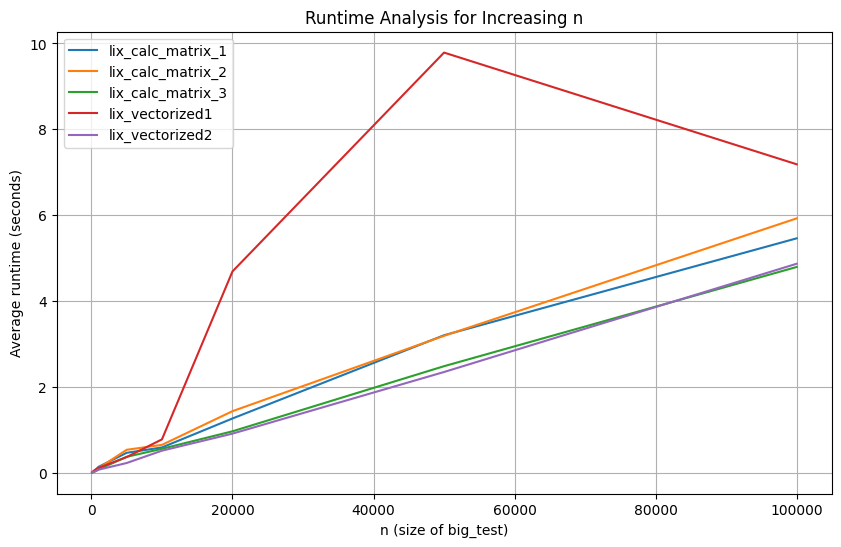

In [1]:
import re
import pandas as pd
from numba import njit
import matplotlib.pyplot as plt
import timeit
import numpy as np

#Basic pythonic lix
def lix_calc1(text):
    # Split text into words by common delimiters
    words = re.findall(r'\b\w+\b', text)
    num_words = max(len(words),1)
    # Count long words (more than 6 letters)
    long_words = sum(1 for word in words if len(word) > 6)
    # Count sentences (approximation using periods)
    sentences = re.split(r'[.!?]', text)
    num_sentences = max(sum(1 for sentence in sentences if sentence.strip()),1)
    # Calculate LIX index
    lix = num_words / num_sentences + (long_words / num_words) * 100
    return lix

#Pythonic LIX with functional constructs
def lix_calc2(text):
    # Split text into words by common delimiters
    words = re.findall(r'\b\w+\b', text)
    num_words = max(len(words),1)
    
    # Count long words (more than 6 letters) using map and sum
    long_words = sum(map(lambda word: len(word) > 6, words))
    
    # Count sentences (approximation using periods, exclamations, and question marks)
    num_sentences = max(sum(map(lambda s: bool(s.strip()), re.split(r'[.!?]', text))),1)
    
    # Calculate LIX index
    lix = num_words / num_sentences + (long_words / num_words) * 100
    return lix

#Optimized pythonic lix
def lix_calc3(text):
    # Split the text into words directly
    words = re.findall(r'\b\w+\b', text)
    num_words = max(len(words),1)

    # Count long words (more than 6 letters)
    long_words = sum(1 for word in words if len(word) > 6)

    # Count sentences by counting delimiters directly
    num_sentences = max(text.count('.') + text.count('!') + text.count('?'),1)
    lix = num_words / num_sentences + (long_words / num_words) * 100
    return lix

#Function to apply simple lix numbers to a matrix (as this is the format of the data from the scraping)
def lix_calc_matrix(matrix, lix_method):
    # Choose the appropriate function based on lix_method
    if lix_method == 1:
        lix_calc = lix_calc1
    elif lix_method == 2:
        lix_calc = lix_calc2
    else:
        lix_calc = lix_calc3
    
    # Calculate LIX score for each text in the matrix
    for m in range(len(matrix)):
        matrix[m][1] = lix_calc(matrix[m][0])
    return matrix
    
#Vectorized Lix with Pandas
def lix_vectorized1(texts):
    # Flatten input and load into a DataFrame
    df = pd.DataFrame([text[0] for text in texts], columns=['text'])

    # Use regex to split text and count words
    df['num_words'] = df['text'].str.findall(r'\b\w+\b').str.len()
    df['num_words'] = df['num_words'].replace(0,1)

    # Count long words (more than 6 letters) in a vectorized manner
    df['long_words'] = df['text'].str.count(r'\b\w{7,}\b')

    # Count sentences by counting punctuation (approximation)
    df['num_sentences'] = df['text'].str.count(r'[.!?]')
    df['num_sentences'] = df['num_sentences'].replace(0, 1)  # Avoid division by zero

    # Calculate LIX index
    df['lix'] = df['num_words'] / df['num_sentences'] + (df['long_words'] / df['num_words']) * 100

    # Return the LIX scores and texts as a list of tuples
    return df[['text', 'lix']].values.tolist()


#Following three functions make up the Hybrid lix with Numba optimization

@njit
def calculate_lix(num_words, long_words, num_sentences):
    # Avoid division by zero
    return num_words / max(num_sentences,1) + (long_words / max(num_words,1)) * 100

def preprocess_texts(texts):
    num_words_list = []
    long_words_list = []
    num_sentences_list = []

    # Preprocess each text for word count, long word count, and sentence count
    for text in texts:
        # Find all words and count them
        words = re.findall(r'\b\w+\b', text)
        num_words = max(len(words),1)
        num_words_list.append(num_words)
        
        # Count long words
        long_words = sum(1 for word in words if len(word) > 6)
        long_words_list.append(long_words)
        
        # Count sentence-ending punctuation marks
        num_sentences = max(1, text.count('.') + text.count('!') + text.count('?'))
        num_sentences_list.append(num_sentences)
    
    return num_words_list, long_words_list, num_sentences_list

def lix_vectorized2(texts):
    # Flatten the input list for DataFrame initialization
    flat_texts = [text[0] for text in texts]
    
    # Preprocess texts for word, long word, and sentence counts
    num_words_list, long_words_list, num_sentences_list = preprocess_texts(flat_texts)
    
    # Use Numba-optimized LIX calculation
    lix_scores = [calculate_lix(num_words, long_words, num_sentences) 
                  for num_words, long_words, num_sentences in zip(num_words_list, long_words_list, num_sentences_list)]
    
    # Return as list of tuples with text and calculated LIX score
    return list(zip(flat_texts, lix_scores))

#Function to get running time of the different lix calculations
def time_functions(n_values,iterations=50,num = 10):
    runtimes = {'lix_calc_matrix_1': [], 'lix_calc_matrix_2': [], 
                'lix_calc_matrix_3': [], 'lix_vectorized1': [], 
                'lix_vectorized2': []}
    
    for n in n_values:
        print(n)
        big_test = [[test, 0] for _ in range(n)]
        
        lix1 = timeit.repeat(lambda: lix_calc_matrix(big_test, 1), repeat=iterations, number=num)
        lix2 = timeit.repeat(lambda: lix_calc_matrix(big_test, 2), repeat=iterations, number=num)
        lix3 = timeit.repeat(lambda: lix_calc_matrix(big_test, 3), repeat=iterations, number=num)
        vec1 = timeit.repeat(lambda: lix_vectorized1(big_test), repeat=iterations, number=num)
        vec2 = timeit.repeat(lambda: lix_vectorized2(big_test), repeat=iterations, number=num)
        
        # Store the average of the repeated runtimes
        runtimes['lix_calc_matrix_1'].append(np.mean(lix1)/num)
        runtimes['lix_calc_matrix_2'].append(np.mean(lix2)/num)
        runtimes['lix_calc_matrix_3'].append(np.mean(lix3)/num)
        runtimes['lix_vectorized1'].append(np.mean(vec1)/num)
        runtimes['lix_vectorized2'].append(np.mean(vec2)/num)
    
    return runtimes


def plot_runtimes_with_custom_legend_order(n_values, runtimes):
    # Map old runtime keys to new descriptive labels
    label_map = {
        'lix_calc_matrix_1': "Basic Pythonic LIX",
        'lix_calc_matrix_2': "Pythonic LIX with Functional Constructs",
        'lix_calc_matrix_3': "Optimized Pythonic LIX with Simplified Sentence Counting",
        'lix_vectorized1': "Vectorized LIX with Pandas",
        'lix_vectorized2': "Hybrid LIX with Numba Optimization",
    }
    
    # Define the custom order for the legend
    custom_order = [
        'lix_vectorized1', 
        'lix_calc_matrix_2', 
        'lix_calc_matrix_1', 
        'lix_vectorized2', 
        'lix_calc_matrix_3'
    ]
    
    # Make the plot relatively taller and wider for better visibility
    plt.figure(figsize=(16, 12))  # Taller and wider figure
    ax = plt.gca()
    
    # Color palette
    COLOR_SCALE = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    for idx, key in enumerate(custom_order):
        # Select color
        color = COLOR_SCALE[idx]
        
        # Plot line with label for legend
        ax.plot(
            n_values, runtimes[key],
            color=color, lw=2.0, label=label_map[key], clip_on=False
        )
    
    # Set x-axis and y-axis to start at 0
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    
    # Customize spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Increase tick and axis label text size
    ax.set_xlabel('n (size of big_test)', fontsize=18)  # Larger x-axis label
    ax.set_ylabel('Average runtime (seconds)', fontsize=18)  # Larger y-axis label
    ax.tick_params(axis='both', labelsize=16)  # Larger tick labels
    
    # Add horizontal grid only
    ax.grid(axis='y', color='gray', linestyle='--', linewidth=0.7, alpha=0.7)
    
    # Add legend as a large box in the top-left corner
    ax.legend(
        loc='upper left', 
        fontsize=18,          # Significantly larger text
        frameon=True,         # Box around the legend
        fancybox=True,        # Rounded edges for the box
        framealpha=1,         # Opaque box
        borderpad=1.5,        # Add padding inside the box
        labelspacing=1.2,     # Increase spacing between legend entries
    )
    
    # Add more space on the right to accommodate labels
    plt.subplots_adjust(right=0.85)  # Increase whitespace on the right
    
    plt.tight_layout()
    # Save the figure in high quality
    plt.savefig("runtimeanalysis_custom_legend_order.png", dpi=300, bbox_inches='tight')
    plt.show()


#Code used to get plots. Takes a long time to run.
def function_used_for_plots():
    test = "LIX er en forkortelse for læsbarhedsindeks (sv. läsbarhetsindex), der er en skala der giver et mål for en teksts læsbarhed. Det opgøres som det gennemsnitlige antal ord pr. helsætning, plus procentdelen af lange ord, altså ord der er over seks bogstaver lange. LIX blev introduceret af den svenske pædagog C.H. Björnsson (1916-1988)."

    n_values = [100, 500, 1000, 5000, 10000, 20000, 50000, 100000]  # Example sizes
    runtimes = time_functions(n_values)
    # Call the function with your data
    plot_runtimes_with_custom_legend_order(n_values, runtimes)